In [ ]:
#Đọc dữ liệu trong google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Test GPU còn khả dụng không (Dùng GPU để hoạt động tốt hơn)
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Lấy các dataset train và test trong file dữ liệu 
train_dir = Path('/content/drive/MyDrive/python2/CNN_CODE/vegetables/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/drive/MyDrive/python2/CNN_CODE/vegetables/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/drive/MyDrive/python2/CNN_CODE/vegetables/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Kết hợp giữa filepaths và labels
    df = pd.concat([filepath, labels], axis=1)

    # Làm xáo trộn(mix) giữa the DataFrame và reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3193

Number of different labels: 36

Labels: ['tomato' 'jalepeno' 'banana' 'carrot' 'potato' 'cauliflower' 'beetroot'
 'garlic' 'eggplant' 'mango' 'soy beans' 'lettuce' 'onion' 'cucumber'
 'pear' 'turnip' 'sweetpotato' 'cabbage' 'corn' 'ginger' 'grapes' 'orange'
 'paprika' 'spinach' 'bell pepper' 'raddish' 'watermelon' 'capsicum'
 'sweetcorn' 'pomegranate' 'chilli pepper' 'lemon' 'peas' 'pineapple'
 'apple' 'kiwi']


In [ ]:
train_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/python2/CNN_CODE/vegeta...,tomato
1,/content/drive/MyDrive/python2/CNN_CODE/vegeta...,jalepeno
2,/content/drive/MyDrive/python2/CNN_CODE/vegeta...,banana
3,/content/drive/MyDrive/python2/CNN_CODE/vegeta...,carrot
4,/content/drive/MyDrive/python2/CNN_CODE/vegeta...,potato


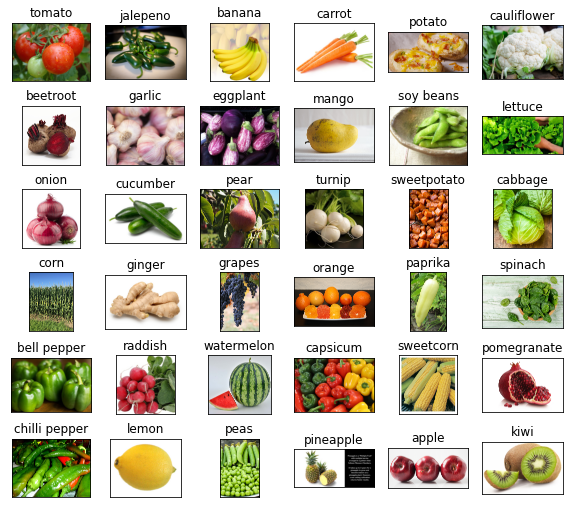

In [ ]:
# Tạo một DataFrame với một Label của mỗi lớp (category)
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Hiển thị một số bức ảnh trong tập dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3193 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [ ]:
# Tạo model có tên là pretrained
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True )])

Epoch 1/10
  3/100 [..............................] - ETA: 12:27 - loss: 3.6290 - accuracy: 0.0312

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 34/100 [=========>....................] - ETA: 11:09 - loss: 2.8862 - accuracy: 0.2978

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


100/100 [==============================] - 1104s 11s/step - loss: 1.8866 - accuracy: 0.5077 - val_loss: 0.4419 - val_accuracy: 0.8802
Epoch 2/10
100/100 [==============================] - 161s 2s/step - loss: 0.7199 - accuracy: 0.7736 - val_loss: 0.2395 - val_accuracy: 0.9401
Epoch 3/10
100/100 [==============================] - 159s 2s/step - loss: 0.4398 - accuracy: 0.8619 - val_loss: 0.1893 - val_accuracy: 0.9431
Epoch 4/10
100/100 [==============================] - 159s 2s/step - loss: 0.3066 - accuracy: 0.9007 - val_loss: 0.1512 - val_accuracy: 0.9431
Epoch 5/10
100/100 [==============================] - 158s 2s/step - loss: 0.1938 - accuracy: 0.9392 - val_loss: 0.1028 - val_accuracy: 0.9671
Epoch 6/10
100/100 [==============================] - 157s 2s/step - loss: 0.1264 - accuracy: 0.9637 - val_loss: 0.0838 - val_accuracy: 0.9701
Epoch 7/10
100/100 [==============================] - 159s 2s/step - loss: 0.0994 - accuracy: 0.9702 - val_loss: 0.0688 - val_accuracy: 0.9790
Epoch 8/

In [ ]:
model.save_weights('model.h5') #Lưu model
#model.load_weights(latest) # load model 

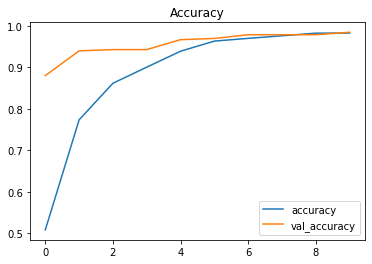

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

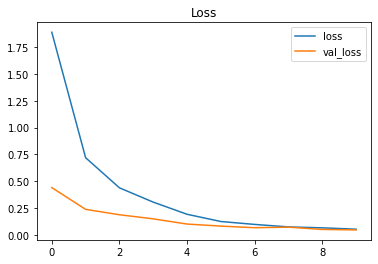

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Dự đoán  label  của test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 98.50%


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


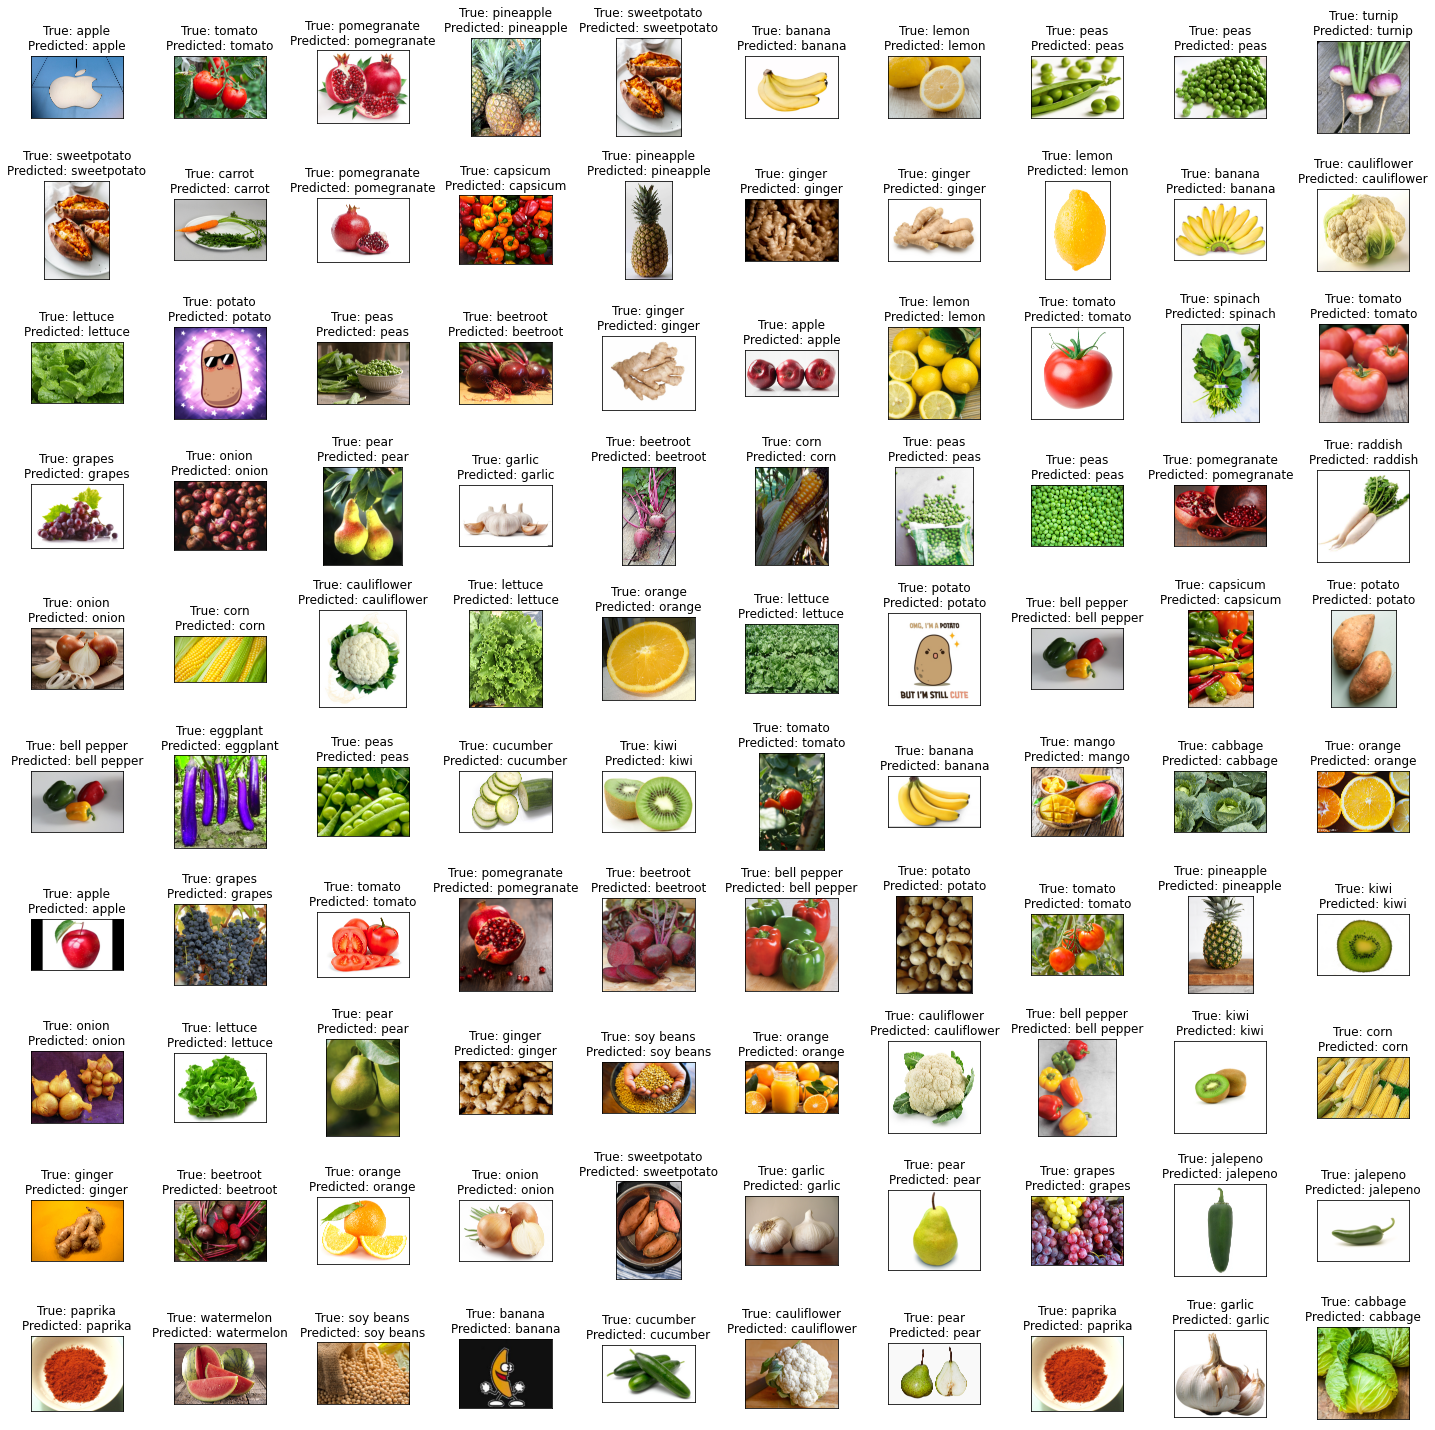

In [ ]:
# Hiển thị ảnh của những bức ảnh test kèm theo kết quả dự đoán và kết quả thực 
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

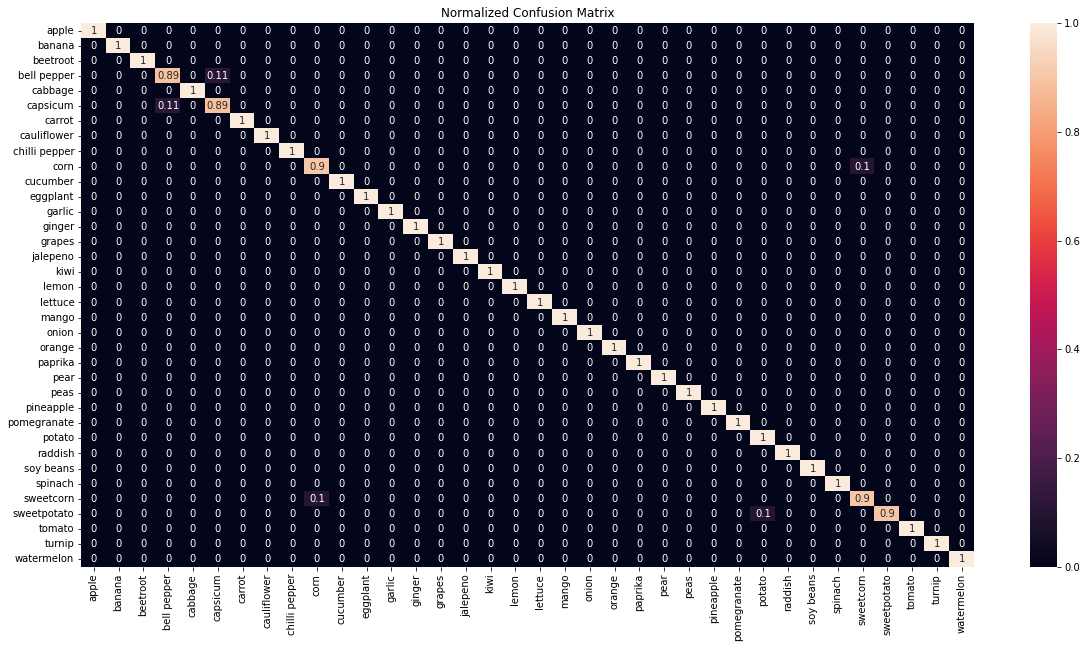

In [ ]:
#Vẽ cái Normalized Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()